IM02 Online Section Group Notebook

#### Business Objective: Which team would be the best to invest in for the upcoming season?

#### Question 1
#### Which teams have most consistently had the highest scores?

In [5]:
import pandas as pd
import sqlite3


#using entire database
con = sqlite3.connect("data/nba.sqlite")
games = pd.read_sql_query("SELECT * FROM game", con)
active_players = pd.read_sql_query("SELECT full_name FROM player WHERE is_active=TRUE", con)


# games data excluding all-star games (2019-2023)

games_recent_5yrs = pd.read_sql_query("""
	SELECT * FROM game 
	WHERE season_type NOT IN ('All Star', 'All-Star') 
	AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

print(games_recent_5yrs.head(5))



  season_id team_id_home team_abbreviation_home  team_name_home     game_id  \
0     42022   1610612743                    DEN  Denver Nuggets  0042200405   
1     42022   1610612748                    MIA      Miami Heat  0042200404   
2     42022   1610612748                    MIA      Miami Heat  0042200403   
3     42022   1610612743                    DEN  Denver Nuggets  0042200402   
4     42022   1610612743                    DEN  Denver Nuggets  0042200401   

             game_date matchup_home wl_home  min  fgm_home  ...  reb_away  \
0  2023-06-12 00:00:00  DEN vs. MIA       W  240      38.0  ...      44.0   
1  2023-06-09 00:00:00  MIA vs. DEN       L  240      35.0  ...      34.0   
2  2023-06-07 00:00:00  MIA vs. DEN       L  240      34.0  ...      58.0   
3  2023-06-04 00:00:00  DEN vs. MIA       L  240      39.0  ...      31.0   
4  2023-06-01 00:00:00  DEN vs. MIA       W  240      40.0  ...      43.0   

   ast_away  stl_away  blk_away  tov_away  pf_away  pts_away  

In [6]:
# mean, standard deviation of scores for each team
score_stats_home = games_recent_5yrs.groupby(['team_id_home','team_name_home'])['pts_home'].agg(['mean', 'std', 'count'])
score_stats_away = games_recent_5yrs.groupby(['team_id_away','team_name_away'])['pts_away'].agg(['mean', 'std', 'count'])

score_stats_home.index.names = ['team_id', 'team_name']
score_stats_away.index.names = ['team_id', 'team_name']

combined_stats = pd.concat([score_stats_home, score_stats_away])
score_stats_all = combined_stats.groupby(['team_id', 'team_name']).mean()
score_stats_all['total_games'] = combined_stats.groupby(['team_id', 'team_name'])['count'].sum()
score_stats_all = score_stats_all[score_stats_all['total_games'] >= 100]


# teams with highest average
print("Teams with highest average scores:")
print(score_stats_all.sort_values(by='mean', ascending=False).head(25))


Teams with highest average scores:
                                         mean        std  count  total_games
team_id    team_name                                                        
1610612749 Milwaukee Bucks         116.435716  12.726194  217.0          434
1610612762 Utah Jazz               114.124126  11.353901  196.5          393
1610612737 Atlanta Hawks           114.082051  12.425118  195.0          390
1610612750 Minnesota Timberwolves  114.046378  11.995903  184.0          368
1610612758 Sacramento Kings        113.760321  12.404773  186.5          373
1610612744 Golden State Warriors   113.553368  12.502250  207.5          415
1610612751 Brooklyn Nets           113.466575  12.269783  195.5          391
1610612740 New Orleans Pelicans    113.429579  11.357125  184.5          369
1610612763 Memphis Grizzlies       113.219401  12.564816  196.5          393
1610612756 Phoenix Suns            113.174049  11.591735  205.5          411
1610612743 Denver Nuggets          112.98

In [9]:
# teams with consistent scoring
print("Most consistent scoring teams (lowest standard deviation):")
print(score_stats_all.sort_values(by='std').head(25))

Most consistent scoring teams (lowest standard deviation):
                                         mean        std  count  total_games
team_id    team_name                                                        
1610612762 Utah Jazz               114.124126  11.353901  196.5          393
1610612739 Cleveland Cavaliers     107.244895  11.354891  182.0          364
1610612740 New Orleans Pelicans    113.429579  11.357125  184.5          369
1610612756 Phoenix Suns            113.174049  11.591735  205.5          411
1610612748 Miami Heat              108.997146  11.596273  217.5          435
1610612761 Toronto Raptors         111.561036  11.654833  203.0          406
1610612743 Denver Nuggets          112.986301  11.774490  219.0          438
1610612753 Orlando Magic           107.049138  11.822853  189.0          378
1610612750 Minnesota Timberwolves  114.046378  11.995903  184.0          368
1610612765 Detroit Pistons         106.855801  11.997323  183.0          366
1610612747 Los An

Text(0.5, 1.0, 'Consistent Scoring Teams (Lowest Standard Deviation)')

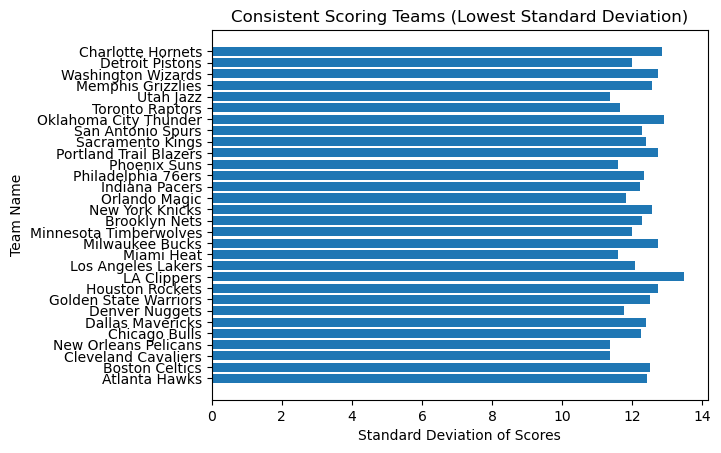

In [29]:
import matplotlib.pyplot as plt
teams_df = pd.DataFrame(score_stats_all).reset_index()
plt.barh(teams_df["team_name"], teams_df["std"])
plt.xlabel("Standard Deviation of Scores")
plt.ylabel("Team Name")
plt.title("Consistent Scoring Teams (Lowest Standard Deviation)")

#### Question 2
#### Which team has had below average for the most consecutive seasons?

In [33]:
# average points per season
season_avg = pd.concat([games_recent_5yrs['pts_home'], games_recent_5yrs['pts_away']]).mean()

home_games = games_recent_5yrs[['season_id', 'team_id_home', 'team_name_home', 'pts_home']].rename(columns={
    'team_id_home': 'team_id',
    'team_name_home': 'team_name',
    'pts_home': 'points'
})
away_games = games_recent_5yrs[['season_id', 'team_id_away', 'team_name_away', 'pts_away']].rename(columns={
    'team_id_away': 'team_id',
    'team_name_away': 'team_name',
    'pts_away': 'points'
})
all_games = pd.concat([home_games, away_games])



In [35]:
# average points per team per season
team_season_avg = all_games.groupby(['season_id', 'team_id', 'team_name'])['points'].mean().reset_index()

# below average seasons
team_season_avg['league_avg'] = season_avg
team_season_avg['below_average'] = team_season_avg['points'] < team_season_avg['league_avg']
team_season_avg = team_season_avg.sort_values(['team_id', 'season_id'])
print(team_season_avg.head(10))

    season_id     team_id       team_name      points  league_avg  \
60      12022       15019  Adelaide 36ers  116.000000  111.924325   
0       12020  1610612737   Atlanta Hawks  112.750000  111.924325   
30      12021  1610612737   Atlanta Hawks  103.250000  111.924325   
61      12022  1610612737   Atlanta Hawks  112.750000  111.924325   
92      22018  1610612737   Atlanta Hawks  116.391304  111.924325   
122     22019  1610612737   Atlanta Hawks  111.761194  111.924325   
152     22020  1610612737   Atlanta Hawks  113.694444  111.924325   
182     22021  1610612737   Atlanta Hawks  113.939024  111.924325   
212     22022  1610612737   Atlanta Hawks  118.426829  111.924325   
274     42020  1610612737   Atlanta Hawks  106.277778  111.924325   

     below_average  
60           False  
0            False  
30            True  
61           False  
92           False  
122           True  
152          False  
182          False  
212          False  
274           True  


Text(0.5, 1.0, 'Teams Consistently Scoring Below Average for the Most Consecutive Seasons')

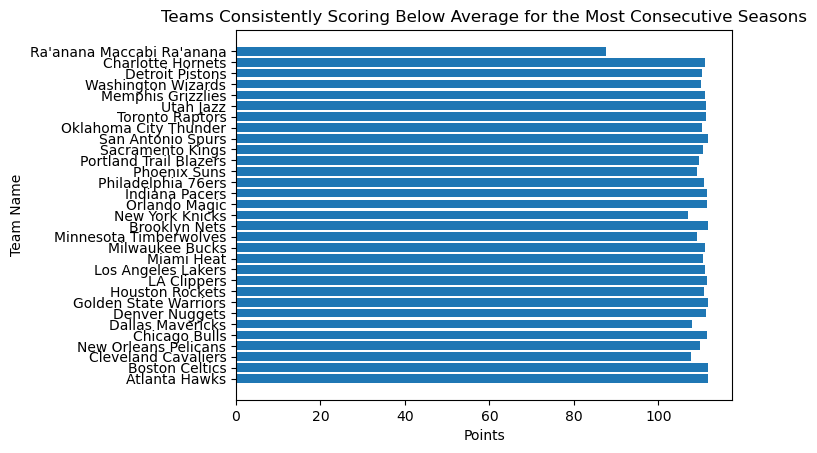

In [41]:
below_df = pd.DataFrame(team_season_avg).reset_index()
below_df_true = below_df[below_df['below_average'] == True]


plt.barh(below_df_true["team_name"], below_df_true["points"])
plt.xlabel("Points")
plt.ylabel("Team Name")
plt.title("Teams Consistently Scoring Below Average for the Most Consecutive Seasons")

#### Question 3 
#### Which team has consistently made it to the playoffs?

In [43]:

# consecutive streaks
def consecutive_streak(group):
   current_streak = 0
   max_streak = 0
   
   for below_avg in group:
       if below_avg:
           current_streak += 1
           max_streak = max(max_streak, current_streak)
       else:
           current_streak = 0
           
   return max_streak

team_streaks = team_season_avg.groupby('team_name')['below_average'].apply(consecutive_streak)
team_streaks = team_streaks.sort_values(ascending=False)

print("Teams with most consecutive below-average seasons:")
print(team_streaks.head(10))


team_streaks = team_streaks.sort_values(ascending=True)

print("Teams with least consecutive below-average seasons:")
print(team_streaks.head(10))


Teams with most consecutive below-average seasons:
team_name
Orlando Magic          9
Detroit Pistons        9
Miami Heat             7
Cleveland Cavaliers    7
Charlotte Hornets      5
Houston Rockets        5
San Antonio Spurs      4
Chicago Bulls          4
New York Knicks        4
Los Angeles Lakers     4
Name: below_average, dtype: int64
Teams with least consecutive below-average seasons:
team_name
Adelaide 36ers               0
Ra'anana Maccabi Ra'anana    1
Golden State Warriors        1
New Orleans Pelicans         1
Sacramento Kings             1
Utah Jazz                    2
Boston Celtics               2
Brooklyn Nets                2
Dallas Mavericks             2
Phoenix Suns                 2
Name: below_average, dtype: int64


In [45]:

# playoff games
playoff_games = games_recent_5yrs[games_recent_5yrs['season_type']=='Playoffs']

# playoff appearances (seasons)
playoff_home_seasons = playoff_games[['season_id', 'team_name_home']].rename(
   columns={'team_name_home': 'team_name'}).drop_duplicates()
playoff_away_seasons = playoff_games[['season_id', 'team_name_away']].rename(
   columns={'team_name_away': 'team_name'}).drop_duplicates()
all_playoff_seasons = pd.concat([playoff_home_seasons, playoff_away_seasons]).drop_duplicates()
playoff_appearances = all_playoff_seasons.groupby('team_name').size().sort_values(ascending=False)

# total playoff games (rounds)
playoff_home_games = playoff_games[['team_name_home', 'game_id']].rename(
   columns={'team_name_home': 'team_name'})
playoff_away_games = playoff_games[['team_name_away', 'game_id']].rename(
   columns={'team_name_away': 'team_name'})
all_playoff_games = pd.concat([playoff_home_games, playoff_away_games])
playoff_games_count = all_playoff_games.groupby('team_name').size()

# playoff appearances, for both seasons & games
playoff_all = pd.DataFrame({
    'team_name': playoff_appearances.index,
    'seasons': playoff_appearances.values,
    'total_games': playoff_games_count.values
})
    
# success rate
total_seasons = games_recent_5yrs['season_id'].nunique()
playoff_all['success_rate'] = (playoff_all['seasons'] / total_seasons * 100)

print("\nPlayoff appearances and games (2019-2023):")
print(playoff_all[['team_name', 'seasons', 'total_games', 'success_rate']])




Playoff appearances and games (2019-2023):
                 team_name  seasons  total_games  success_rate
0            Brooklyn Nets        5           29     38.461538
1           Denver Nuggets        5           75     38.461538
2       Philadelphia 76ers        5           29     38.461538
3          Milwaukee Bucks        5            5     38.461538
4           Boston Celtics        5            5     38.461538
5               Miami Heat        4           31     30.769231
6                Utah Jazz        4           68     30.769231
7              LA Clippers        4            4     30.769231
8        Memphis Grizzlies        3           57     23.076923
9          Toronto Raptors        3           23     23.076923
10  Portland Trail Blazers        3            8     23.076923
11            Phoenix Suns        3           43     23.076923
12           Atlanta Hawks        3           43     23.076923
13      Los Angeles Lakers        3           23     23.076923
14   Golden

Text(0.5, 1.0, 'Teams Who Made it to the Playoffs')

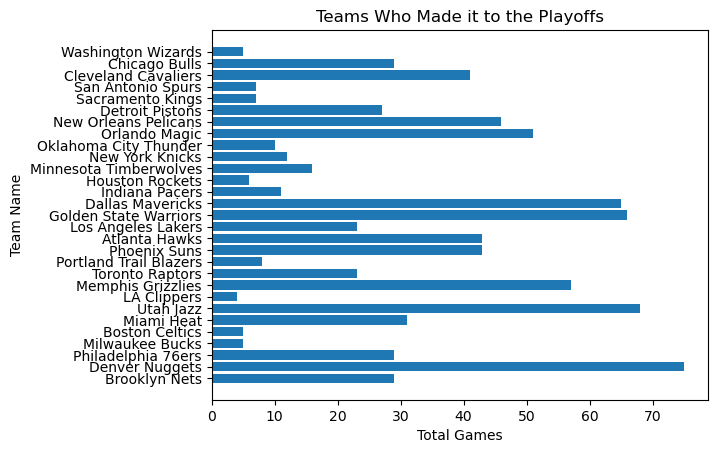

In [47]:
playoffs_df = pd.DataFrame(playoff_all).reset_index()


plt.barh(playoffs_df["team_name"], playoffs_df["total_games"])
plt.xlabel("Total Games")
plt.ylabel("Team Name")
plt.title("Teams Who Made it to the Playoffs")

#### Question 4
#### Which teams have shown the greatest improvement over the past five years?

In [51]:
#Question 4: Which teams have shown the greatest improvement over the past five years?
# extract year from game_date
games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

# limit to regular season
regular_games = games_recent_5yrs[games_recent_5yrs['season_type']=='Regular Season']

# home and away game data 
reg_home_games = regular_games[['team_name_home', 'game_year', 'pts_home']].rename(
    columns={'team_name_home': 'team_name', 'pts_home': 'points'})
reg_away_games = regular_games[['team_name_away', 'game_year', 'pts_away']].rename(
    columns={'team_name_away': 'team_name', 'pts_away': 'points'})
reg_all_games = pd.concat([reg_home_games, reg_away_games])

# average points for each team by year
team_year_avg = reg_all_games.groupby(['team_name', 'game_year'])['points'].mean().reset_index()

# improvement
improvement_list = []

for team in team_year_avg['team_name'].unique():
    team_data = team_year_avg[team_year_avg['team_name'] == team].sort_values('game_year')
    
    total_improvement = team_data['points'].diff().sum() 
    
    improvement_list.append({
        'team_name_home': team, 
        'total_improvement': total_improvement
    })

team_improvement = pd.DataFrame(improvement_list)
team_improvement = team_improvement.sort_values(by='total_improvement', ascending=False)

print("Teams with the greatest improvement over the past five years:")
print(team_improvement.head(20))


Teams with the greatest improvement over the past five years:
            team_name_home  total_improvement
19         New York Knicks          14.695726
25        Sacramento Kings          12.650000
14       Memphis Grizzlies          10.526330
0            Atlanta Hawks           9.028261
11          Indiana Pacers           8.326020
9    Golden State Warriors           7.655134
5      Cleveland Cavaliers           7.627350
13      Los Angeles Lakers           6.813824
20   Oklahoma City Thunder           6.298844
21           Orlando Magic           5.524613
7           Denver Nuggets           5.377463
4            Chicago Bulls           5.149422
1           Boston Celtics           4.875494
28               Utah Jazz           4.740310
22      Philadelphia 76ers           4.458629
6         Dallas Mavericks           4.343460
3        Charlotte Hornets           4.276423
17  Minnesota Timberwolves           4.053968
12             LA Clippers           2.143659
15              Mi

Text(0.5, 1.0, 'Teams and Improvements Over Past 5 Years')

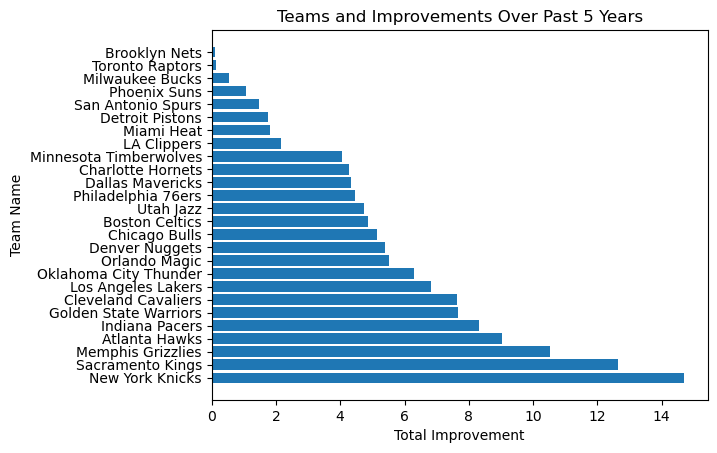

In [57]:
team_improvement_improved = team_improvement[team_improvement["total_improvement"]>0]
plt.barh(team_improvement_improved["team_name_home"], team_improvement_improved["total_improvement"])
plt.xlabel("Total Improvement")
plt.ylabel("Team Name")
plt.title("Teams and Improvements Over Past 5 Years")

#### Question 5
#### Which teams have demonstrated the best defensive metrics (e.g., blocks and steals), and how has this impacted their winning consistency?

#### Rising Action

Our analysis uncovered compelling defensive patterns across NBA teams. The Memphis Grizzlies demonstrated exceptional defensive metrics, leading with 5.62 blocks and 8.65 steals per game, while the Toronto Raptors excelled specifically in steals with 8.91 per game. These metrics stand out historically, but they raise critical investment questions.

To truly understand the investment potential, we needed to look beyond raw defensive statistics. How well do these defensive metrics translate to actual team success? Are teams with elite defensive numbers consistently outperforming the market? By examining the correlation between defensive prowess and winning percentage, we aim to identify teams that combine defensive excellence with proven success - a potential indicator of sustainable long-term value.

In [59]:
import pandas as pd
import sqlite3 
con = sqlite3.connect("data/nba.sqlite")
games_recent_5yrs = pd.read_sql_query("""
	SELECT * FROM game 
	WHERE season_type NOT IN ('All Star', 'All-Star') 
	AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

regular_games = games_recent_5yrs[games_recent_5yrs['season_type']=='Regular Season']

# home games stats
home_defense = regular_games[['team_name_home', 'blk_home', 'stl_home', 'wl_home']].rename(
   columns={'team_name_home': 'team_name', 
           'blk_home': 'blocks',
           'stl_home': 'steals',
           'wl_home': 'win_loss'})

# away games stats
away_defense = regular_games[['team_name_away', 'blk_away', 'stl_away', 'wl_away']].rename(
   columns={'team_name_away': 'team_name',
           'blk_away': 'blocks', 
           'stl_away': 'steals',
           'wl_away': 'win_loss'})

# defense metrics
all_defense = pd.concat([home_defense, away_defense])
defense_stats = all_defense.groupby('team_name').agg(
    avg_blocks=('blocks', 'mean'),
    avg_steals=('steals', 'mean')
).reset_index()

# win rate 
wins = all_defense[all_defense['win_loss'] == 'W'].groupby('team_name').size()
total_games = all_defense.groupby('team_name').size()
win_rates = (wins / total_games).reset_index(name='win_rate')

# defense rating
defense_analysis = pd.merge(defense_stats, win_rates, on='team_name')
defense_analysis['defense_rating'] = defense_analysis['avg_blocks'] + defense_analysis['avg_steals']
defense_sorted = defense_analysis.sort_values(
   by=['defense_rating', 'win_rate'], 
   ascending=[False, False]
)

print("Teams with the best defensive metrics:")
print(defense_sorted.head(10))

Teams with the best defensive metrics:
                 team_name  avg_blocks  avg_steals  win_rate  defense_rating
14       Memphis Grizzlies    5.619718    8.653521  0.546479       14.273239
27         Toronto Raptors    5.036932    8.914773  0.568182       13.951705
17  Minnesota Timberwolves    5.397101    8.423188  0.431884       13.820290
22      Philadelphia 76ers    5.336158    8.050847  0.635593       13.387006
11          Indiana Pacers    5.576271    7.731638  0.457627       13.307910
1           Boston Celtics    5.485876    7.502825  0.621469       12.988701
13      Los Angeles Lakers    5.355114    7.508523  0.528409       12.863636
9    Golden State Warriors    4.713043    8.043478  0.530435       12.756522
10         Houston Rockets    4.810734    7.892655  0.381356       12.703390
23            Phoenix Suns    4.628895    7.824363  0.577904       12.453258


#### Climax

The data reveals a compelling investment story through defensive metrics and winning consistency. The Milwaukee Bucks emerge as the top performer with a league-leading 69.1% win rate while maintaining solid defensive numbers (5.0 blocks, 7.4 steals). Following closely, the Philadelphia 76ers demonstrate exceptional defensive capabilities with 5.3 blocks and 8.1 steals, translating to a 63.6% win rate. The Denver Nuggets and Boston Celtics round out the top tier, each converting strong defensive metrics into win rates above 62%.
Particularly noteworthy is that while teams like the Toronto Raptors show superior defensive statistics (ranking highest in total defense rating at 13.95), their lower win rate (56.8%) suggests challenges in converting defensive excellence into consistent victories.

This pattern indicates that for investment purposes, teams successfully balancing defensive capabilities with winning consistency, like the Bucks and 76ers, represent more stable investment opportunities.


In [61]:
defense_sorted = defense_analysis.sort_values(
   by=['win_rate', 'defense_rating'], 
   ascending=[False, False]
)

print("Teams with the best defensive metrics and their winning consistency:")
print(defense_sorted.head(10))

Teams with the best defensive metrics and their winning consistency:
             team_name  avg_blocks  avg_steals  win_rate  defense_rating
16     Milwaukee Bucks    4.957865    7.359551  0.691011       12.317416
22  Philadelphia 76ers    5.336158    8.050847  0.635593       13.387006
7       Denver Nuggets    4.296919    7.627451  0.630252       11.924370
1       Boston Celtics    5.485876    7.502825  0.621469       12.988701
28           Utah Jazz    5.056657    6.603399  0.606232       11.660057
12         LA Clippers    4.564972    7.211864  0.590395       11.776836
23        Phoenix Suns    4.628895    7.824363  0.577904       12.453258
15          Miami Heat    3.823034    7.676966  0.570225       11.500000
27     Toronto Raptors    5.036932    8.914773  0.568182       13.951705
2        Brooklyn Nets    5.235795    6.821023  0.559659       12.056818


Text(0.5, 1.0, 'Relationship Between Defensive Performance and Win Rate')

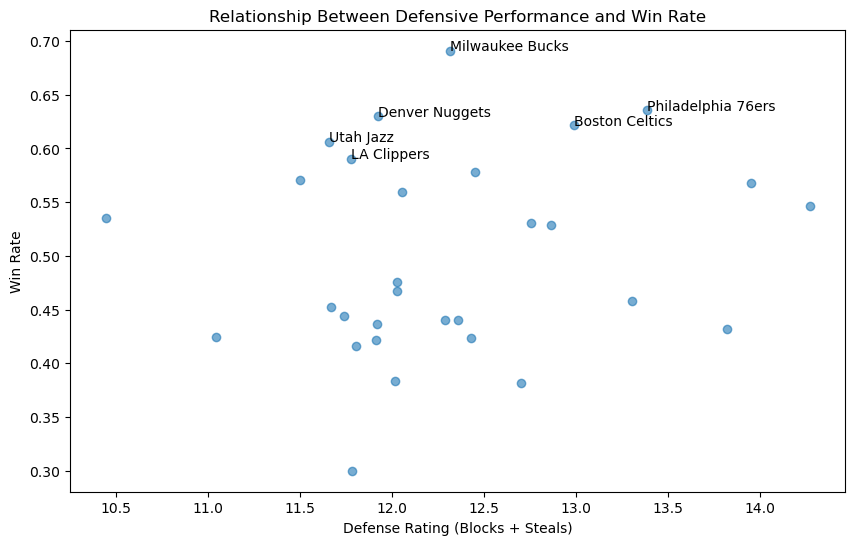

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(defense_sorted['defense_rating'], 
           defense_sorted['win_rate'], 
           alpha=0.6)

for idx, row in defense_sorted.head(6).iterrows():
    plt.annotate(row['team_name'], 
                (row['defense_rating'], row['win_rate']))

plt.xlabel('Defense Rating (Blocks + Steals)')
plt.ylabel('Win Rate')
plt.title('Relationship Between Defensive Performance and Win Rate')



#### Climax

Analysis reveals surprisingly weak correlations between defensive metrics and winning performance, with blocks (0.223), steals (0.061), and overall defense rating (0.167) showing minimal correlation with win rates. The scatter plots visualize this disconnect clearly - teams with high defensive ratings frequently fail to achieve corresponding win rates.
These findings challenge conventional wisdom about defensive metrics as team performance indicators. For instance, while the Toronto Raptors excel in defensive statistics, their lower win rate demonstrates that defensive prowess alone doesn't guarantee success. The scattered distribution across all metrics suggests investors need a more comprehensive evaluation framework beyond defensive capabilities to assess team potential.



Correlation with win rate:
Blocks: 0.223
Steals: 0.061
Defense Rating: 0.167


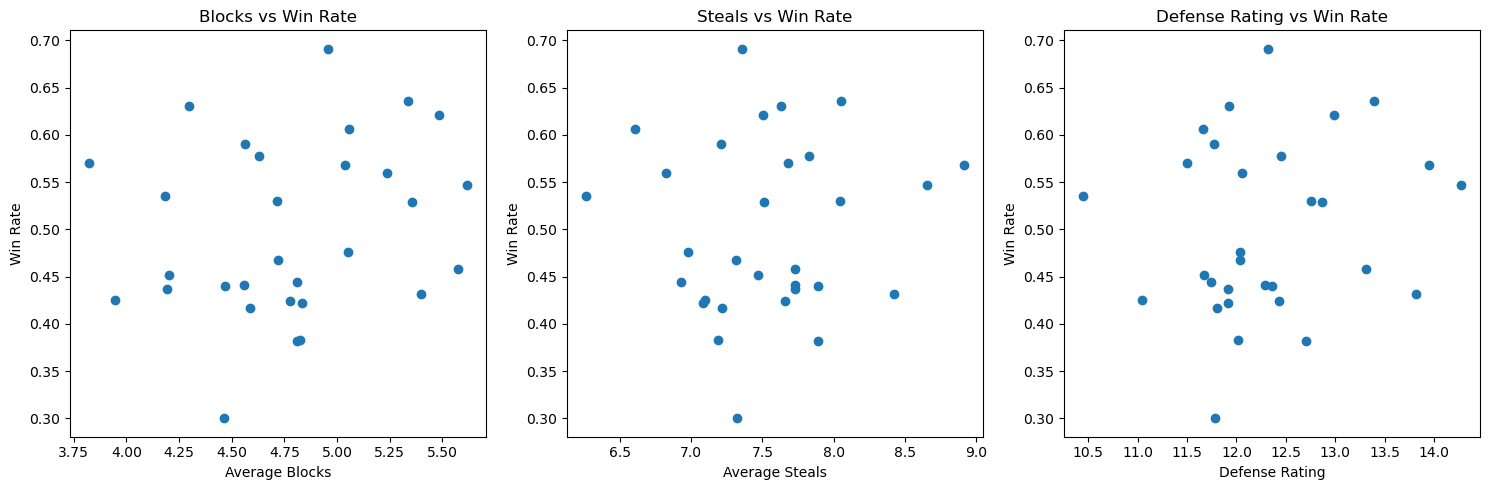

In [7]:
# Calculate correlations
correlations = defense_analysis[['avg_blocks', 'avg_steals', 'defense_rating', 'win_rate']].corr()

print("\nCorrelation with win rate:")
print("Blocks:", correlations.loc['avg_blocks', 'win_rate'].round(3))
print("Steals:", correlations.loc['avg_steals', 'win_rate'].round(3))
print("Defense Rating:", correlations.loc['defense_rating', 'win_rate'].round(3))

# Create scatter plots to visualize relationships
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(defense_analysis['avg_blocks'], defense_analysis['win_rate'])
axes[0].set_title('Blocks vs Win Rate')
axes[0].set_xlabel('Average Blocks')
axes[0].set_ylabel('Win Rate')

axes[1].scatter(defense_analysis['avg_steals'], defense_analysis['win_rate'])
axes[1].set_title('Steals vs Win Rate')
axes[1].set_xlabel('Average Steals')
axes[1].set_ylabel('Win Rate')

axes[2].scatter(defense_analysis['defense_rating'], defense_analysis['win_rate'])
axes[2].set_title('Defense Rating vs Win Rate')
axes[2].set_xlabel('Defense Rating')
axes[2].set_ylabel('Win Rate')

plt.tight_layout()
plt.show()


#### Falling action

The disconnect between defensive metrics and win rates has significant market implications. Valuation heavily weighing defensive statistics may be overvaluing certain teams while missing other investment opportunities. This misalignment creates potential market inefficiencies, particularly in teams like the Milwaukee Bucks and Philadelphia 76ers, who demonstrate success beyond pure defensive excellence. Moreover, teams focusing solely on defensive improvement might be misallocating resources, suggesting a need for a more balanced approach to team development and valuation.


#### Resolution

Based on our analysis, we identify three distinct investment categories:

1. Premium Investments (Milwaukee Bucks, Philadelphia 76ers):
 - Balance of defensive capability and winning consistency
 - Proven ability to convert defensive skills into victories
 - Most stable investment prospects
2. Value Opportunities (Denver Nuggets, Boston Celtics):
 - Strong overall performance metrics
 - Effective translation of defensive capabilities into wins
3. Cautionary Investments (Toronto Raptors, Memphis Grizzlies):
 - Superior defensive statistics but lower win rates
 - Need for additional performance factors beyond defense
 - Higher risk profile despite strong defensive metrics

The Milwaukee Bucks and Philadelphia 76ers stand out as particularly attractive investments, demonstrating the crucial balance between defensive capabilities and consistent winning performance.
